In [7]:
import os
import csv
import json
import time
import math
from collections import Counter

import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModelForSequenceClassification

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, 
    precision_recall_fscore_support, 
    confusion_matrix, 
    classification_report
)

from transformers import AutoTokenizer, AutoModelForSequenceClassification

from torch.utils.data import random_split

In [8]:
class MusicXMLDataset(Dataset):
    def __init__(self, json_path, tokenizer, max_len=512):
        # Load the preprocessed entries from the JSON file
        with open(json_path, 'r', encoding='utf-8') as f:
            self.entries = json.load(f)
        # Filter entries if needed 
        self.entries = [entry for entry in self.entries if (
            "/mxl/0/" in entry['mxl'] or
            "/mxl/1/" in entry['mxl'] or
            "/mxl/2/" in entry['mxl'] or
            "/mxl/3/" in entry['mxl'] or
            "/mxl/4/" in entry['mxl']
        )]
        # Enumerate unique genres and create a mapping to indices
        unique_genres = sorted({entry['primary_genre'] for entry in self.entries})
        print("PRIMARY GENRES:", set(unique_genres))
        self.genre_to_idx = {genre: idx for idx, genre in enumerate(unique_genres)}
        self.idx_to_genre = {idx: genre for genre, idx in self.genre_to_idx.items()}
        
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        entry = self.entries[idx]
        # Parse the token list from the JSON field (it's stored as a JSON string)
        tokens = json.loads(entry['tokens'])  # this yields a list of token strings
        # Convert the list of tokens to the format expected by the tokenizer.
        # We use the tokenizer to get input IDs and attention mask, padding to max_len.
        encoding = self.tokenizer(
            tokens, 
            is_split_into_words=True,       # treat the list of tokens as pre-split words
            add_special_tokens=True,        # add [CLS], [SEP] as needed for the model
            truncation=True, 
            padding='max_length', 
            max_length=self.max_len,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze(0)         # tensor of shape (max_len)
        attention_mask = encoding['attention_mask'].squeeze(0)  # tensor of shape (max_len)
        # Genre label to index
        genre_str = entry['primary_genre']
        label = torch.tensor(self.genre_to_idx[genre_str], dtype=torch.long)
        return input_ids, attention_mask, label


In [9]:
def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for input_ids, attention_mask, labels in dataloader:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)


In [10]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for input_ids, attention_mask, labels in dataloader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = criterion(logits, labels)
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)
    accuracy = sum([p == l for p, l in zip(all_preds, all_labels)]) / len(all_labels)
    return total_loss / len(dataloader), accuracy, precision, recall, f1


In [11]:
def plot_training_curves(train_losses, val_losses, val_accuracies, val_precisions, val_recalls, val_f1s):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(14, 5))

    # Subplot 1: Losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', linestyle='--', marker='o')
    plt.plot(epochs, val_losses, label='Val Loss', linestyle='-', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.grid(True)

    # Subplot 2: Metrics
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label='Accuracy', marker='o')
    plt.plot(epochs, val_precisions, label='Precision', marker='o')
    plt.plot(epochs, val_recalls, label='Recall', marker='o')
    plt.plot(epochs, val_f1s, label='F1 Score', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.title('Validation Metrics')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("genre_curves.png")
    plt.show()

In [12]:
def train_with_early_stopping(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=10, patience=3):
    train_losses = []
    val_losses = []
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1s = []

    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        train_loss = train_model(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc, val_precision, val_recall, val_f1 = evaluate_model(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)

        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | "
              f"P: {val_precision:.4f} | R: {val_recall:.4f} | F1: {val_f1:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    plot_training_curves(train_losses, val_losses, val_accuracies, val_precisions, val_recalls, val_f1s)
    return model

In [13]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set your seed
set_seed(42)

In [14]:
# Choose pre-trained model
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load your dataset
json_path = "/kaggle/input/mlx-dataset/preprocessed_dataset.json"  # <-- put your JSON path here
dataset = MusicXMLDataset(json_path, tokenizer, max_len=512)
num_classes = len(dataset.genre_to_idx)

# Load pre-trained model with correct number of output classes
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)

# Freeze all layers
for param in model.base_model.parameters():
    param.requires_grad = False

# Unfreeze the last 2 layers of DistilBERT encoder
for layer in model.base_model.transformer.layer[-1:]:
    for param in layer.parameters():
        param.requires_grad = True
    
# Train-validation-test split
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = int(0.1 * len(dataset))    # 10% for validation
test_size = len(dataset) - train_size - val_size  # Remaining 10% for testing

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer and Loss
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5)
criterion = nn.CrossEntropyLoss()


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

PRIMARY GENRES: {'Soundtrack', 'R&B, Soul & Hip-Hop', 'Pop', 'Religious', 'Folk/World', 'Electronic & Dance', 'Jazz & Blues', 'Rock & Metal', 'Classical'}


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/100
Train Loss: 1.8110 | Val Loss: 1.6577 | Acc: 0.4297 | P: 0.3043 | R: 0.4297 | F1: 0.3552
Epoch 2/100
Train Loss: 1.6300 | Val Loss: 1.5271 | Acc: 0.4847 | P: 0.3523 | R: 0.4847 | F1: 0.4070
Epoch 3/100
Train Loss: 1.5579 | Val Loss: 1.4815 | Acc: 0.5132 | P: 0.3877 | R: 0.5132 | F1: 0.4370
Epoch 4/100
Train Loss: 1.5141 | Val Loss: 1.4678 | Acc: 0.5193 | P: 0.4156 | R: 0.5193 | F1: 0.4565
Epoch 5/100
Train Loss: 1.4809 | Val Loss: 1.4970 | Acc: 0.5010 | P: 0.3787 | R: 0.5010 | F1: 0.4193
Epoch 6/100
Train Loss: 1.4609 | Val Loss: 1.4228 | Acc: 0.5092 | P: 0.4146 | R: 0.5092 | F1: 0.4502
Epoch 7/100
Train Loss: 1.4308 | Val Loss: 1.4540 | Acc: 0.5173 | P: 0.4004 | R: 0.5173 | F1: 0.4454
Epoch 8/100
Train Loss: 1.4172 | Val Loss: 1.4205 | Acc: 0.5173 | P: 0.4227 | R: 0.5173 | F1: 0.4640
Epoch 9/100
Train Loss: 1.3958 | Val Loss: 1.4185 | Acc: 0.5071 | P: 0.4046 | R: 0.5071 | F1: 0.4470
Epoch 10/100
Train Loss: 1.3795 | Val Loss: 1.4163 | Acc: 0.5132 | P: 0.4101 | R: 0.5132 | 

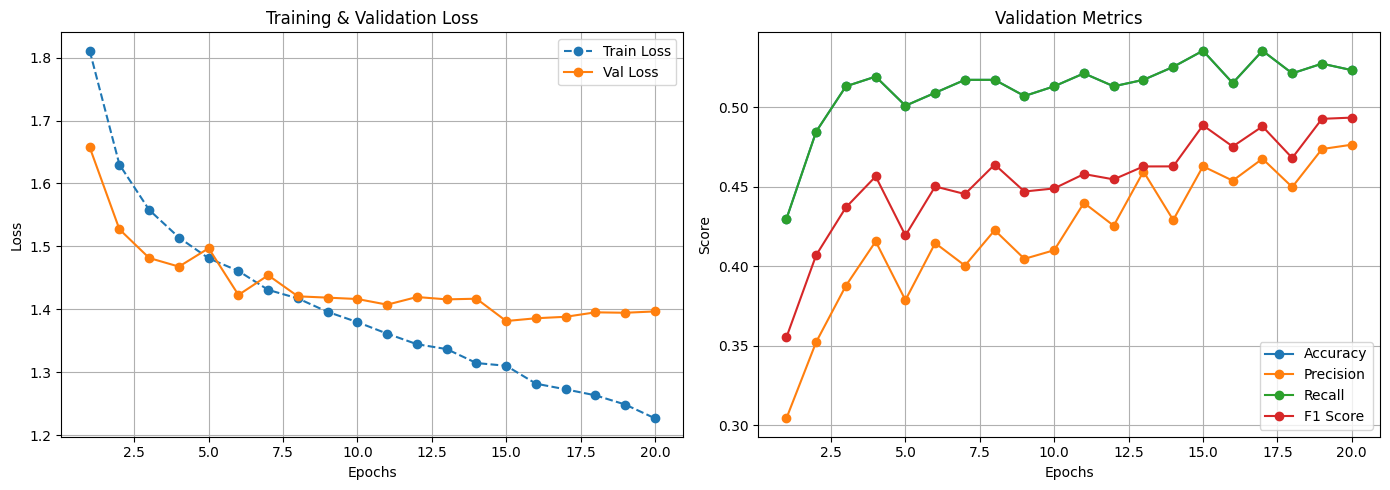

In [15]:
trained_model = train_with_early_stopping(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=100,
    patience=5
)

In [16]:
torch.save(trained_model.state_dict(), "genre_classifier.pt")

In [28]:
def evaluate_model(model, test_dataloader, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_dataloader:
            # Unpack the batch for this specific dataset structure
            inputs, attention_mask, labels = batch
            inputs = inputs.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            # Perform model inference
            outputs = model(input_ids=inputs, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits if hasattr(outputs, 'logits') else outputs
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Get unique labels to pass to precision_recall_fscore_support
    unique_labels = np.unique(np.concatenate((all_labels, all_preds)))
    
    # Calculating metrics with zero_division to handle labels with no predictions
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, support = precision_recall_fscore_support(
        all_labels, 
        all_preds, 
        labels=unique_labels,
        average=None,  # Get per-class metrics
        zero_division=0  # Set to 0 instead of raising a warning
    )

    # Weighted average metrics
    w_precision, w_recall, w_f1, _ = precision_recall_fscore_support(
        all_labels, 
        all_preds, 
        average='weighted', 
        zero_division=0
    )

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=unique_labels)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support,
        'weighted_precision': w_precision,
        'weighted_recall': w_recall,
        'weighted_f1': w_f1,
        'confusion_matrix': cm,
        'predictions': all_preds,
        'true_labels': all_labels
    }

def plot_confusion_matrix(cm, class_names=None, title='Confusion Matrix', normalize=False):
    plt.figure(figsize=(16, 12))
    
    # If no class names provided, use numeric labels
    if class_names is None:
        class_names = [str(i) for i in range(cm.shape[0])]
    
    if normalize:
        # Normalize the confusion matrix
        cm_plot = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2%'
        cbar_label = 'Normalized Percentage'
        plot_title = f'{title} - Normalized Percentages'
    else:
        cm_plot = cm
        fmt = 'd'
        cbar_label = 'Absolute Count'
        plot_title = f'{title} - Absolute Counts'
    
    sns.heatmap(cm_plot, 
                annot=True,  
                fmt=fmt,     
                cmap='YlGnBu', 
                xticklabels=class_names, 
                yticklabels=class_names,
                cbar_kws={'label': cbar_label})
    plt.title(plot_title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Save with a descriptive filename
    filename = f"confusion_matrix_{'normalized' if normalize else 'absolute'}.png"
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.show()

def print_detailed_metrics(evaluation_results, class_names=None):
    """
    Prints a comprehensive breakdown of model performance metrics.
    
    Args:
        evaluation_results (dict): Dictionary containing evaluation metrics
        class_names (list, optional): List of class names corresponding to indices
    """
    print("\n===== Model Performance Metrics =====")
    print(f"Overall Accuracy: {evaluation_results['accuracy']:.4f}")
    print(f"Weighted Precision: {evaluation_results['weighted_precision']:.4f}")
    print(f"Weighted Recall: {evaluation_results['weighted_recall']:.4f}")
    print(f"Weighted F1-Score: {evaluation_results['weighted_f1']:.4f}")
    
    print("\n===== Per-Class Metrics =====")
    if class_names is None:
        class_names = [str(i) for i in range(len(evaluation_results['precision']))]
    
    # Create a formatted table of per-class metrics
    print(f"{'Class':<20} {'Precision':>10} {'Recall':>10} {'F1-Score':>10} {'Support':>10}")
    print("-" * 70)
    for i, (name, p, r, f1, sup) in enumerate(zip(
        class_names, 
        evaluation_results['precision'], 
        evaluation_results['recall'], 
        evaluation_results['f1'], 
        evaluation_results['support']
    )):
        print(f"{name:<20} {p:10.4f} {r:10.4f} {f1:10.4f} {sup:10.0f}")

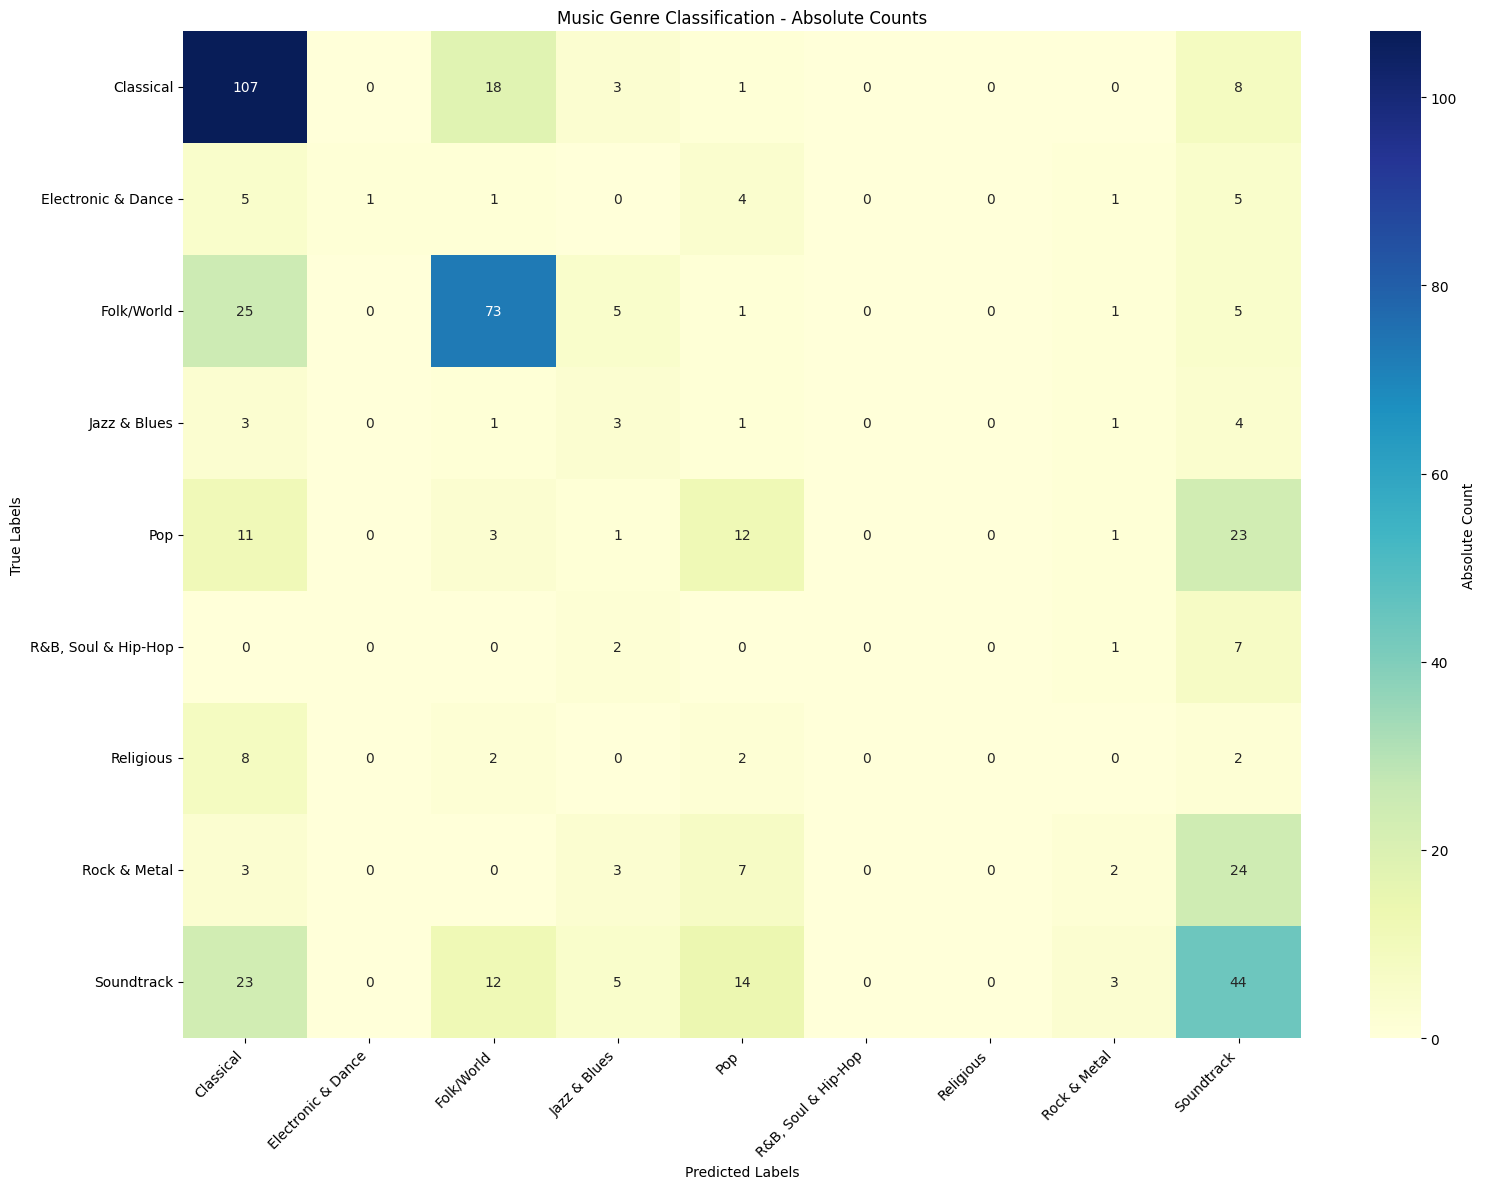

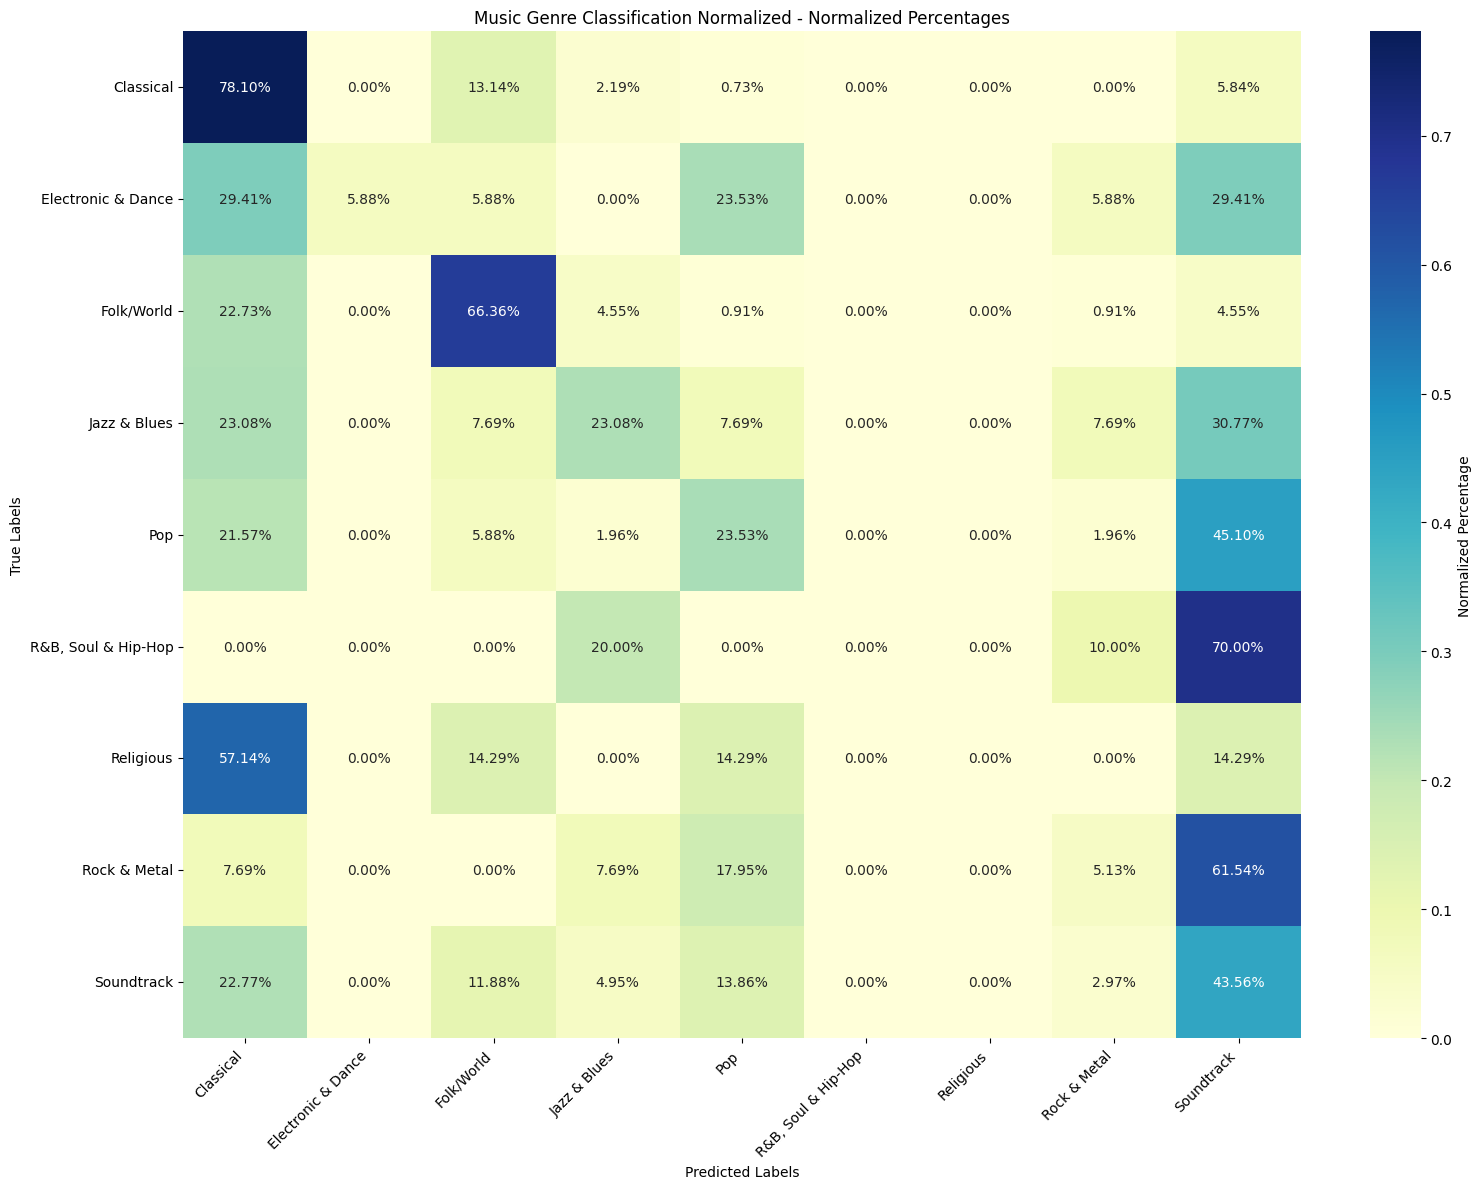


===== Model Performance Metrics =====
Overall Accuracy: 0.4919
Weighted Precision: 0.4671
Weighted Recall: 0.4919
Weighted F1-Score: 0.4560

===== Per-Class Metrics =====
Class                 Precision     Recall   F1-Score    Support
----------------------------------------------------------------------
Classical                0.5784     0.7810     0.6646        137
Electronic & Dance       1.0000     0.0588     0.1111         17
Folk/World               0.6636     0.6636     0.6636        110
Jazz & Blues             0.1364     0.2308     0.1714         13
Pop                      0.2857     0.2353     0.2581         51
R&B, Soul & Hip-Hop      0.0000     0.0000     0.0000         10
Religious                0.0000     0.0000     0.0000         14
Rock & Metal             0.2000     0.0513     0.0816         39
Soundtrack               0.3607     0.4356     0.3946        101


In [29]:
# Get class names from the dataset
class_names = list(test_dataset.dataset.genre_to_idx.keys())

evaluation_results = evaluate_model(trained_model, test_loader, device)

plot_confusion_matrix(
    evaluation_results['confusion_matrix'], 
    class_names=class_names, 
    title='Music Genre Classification',
    normalize=False 
)

plot_confusion_matrix(
    evaluation_results['confusion_matrix'], 
    class_names=class_names, 
    title='Music Genre Classification Normalized',
    normalize=True  # Normalized percentages
)

print_detailed_metrics(evaluation_results, class_names)